In [1]:
#%xmode Verbose

In [2]:
import sys
sys.path.append("../libs/")
sys.path.append("../../../deep-belief-network/")

In [3]:
from dbn.models import SupervisedDBNRegression

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import shift_join_data, mae,rmse,mape, plot_pred, plot_history, split_df, flatten
from keras.models import load_model

# Carga de datos

In [5]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [6]:
#df_train, df_test = split_df(df, 0.3)
#df_val = df_test.copy()

In [7]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [9]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [10]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [11]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


In [47]:
_, df_test = split_df(df,0.4)

g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_temp.loc[ : test_year].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_temp.loc[test_year : ].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_temp.loc[ : test_year].copy())
g:\tesis\2022-1\codigo\gdp_growth_forecasting\modelamiento\../libs\utils.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

# Normalizar

In [48]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

# minmax_scaler_x_train = MinMaxScaler()
# minmax_scaler_y_train = MinMaxScaler()
# minmax_scaler_x_test = MinMaxScaler()
# minmax_scaler_y_test = MinMaxScaler()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

# df_x_train.iloc[:,:] = minmax_scaler_x_train.fit_transform(df_x_train)
# df_y_train.iloc[:,:] = minmax_scaler_y_train.fit_transform(df_y_train)
# df_x_test.iloc[:,:] = minmax_scaler_x_test.fit_transform(df_x_test)
# df_y_test.iloc[:,:] = minmax_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-3,3)
df_y_train.iloc[:,:] = np.clip(df_y_train,-3,3)
df_x_test.iloc[:,:] = np.clip(df_x_test,-3,3)
df_y_test.iloc[:,:] = np.clip(df_y_test,-3,3)

# Generar variables lag y horizonte

In [49]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)

In [17]:
n_batch = len(x_train)

In [18]:
n_batch

1695

In [19]:
#mlp = build_mlp(n_steps_in,n_features,n_steps_out,304,4,1e-4,'relu')
#model = load_model('ajustes/Seq2Seq_20220724_2143.h5')

In [20]:
nodes = 200
rbm_layers = 3
h_layers_structure = [nodes for i in range(rbm_layers)]
learning_rate_rbm=1e-4
learning_rate=1e-2
n_epochs = 20
n_iter_backprop=200
batch_size=32
activation_function='relu'
dropout_p = 0.1

In [21]:
model = SupervisedDBNRegression(
    hidden_layers_structure = h_layers_structure,
    learning_rate_rbm = learning_rate_rbm,
    learning_rate = learning_rate,
    n_epochs_rbm = n_epochs,
    n_iter_backprop = n_iter_backprop,
    batch_size = batch_size,
    activation_function = activation_function,
    dropout_p = dropout_p,
    verbose = False
)

In [50]:
x_train = flatten(x_train)
x_test = flatten(x_test)
#y_train = y_train.flatten()
#y_test = y_test.flatten()

In [23]:
model.fit(x_train, y_train)

SupervisedDBNRegression()

In [24]:
#history = model.fit(x_train,y_train,epochs=2000,batch_size=32,validation_split=0.3,verbose=0,callbacks=[es],shuffle=False)

In [25]:
#plot_history(history,'loss')

In [51]:
y_pred = model.predict(x_test)

In [27]:
#shape = y_pred.shape
#y_pred = y_pred.reshape(shape[0],shape[1])

In [52]:
# dn_y_test = minmax_scaler_y_test.inverse_transform(y_test)
# dn_y_pred = minmax_scaler_y_test.inverse_transform(y_pred)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [53]:
print(mae(dn_y_test, dn_y_pred))
print(rmse(dn_y_test, dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

[1.78772889 2.8698415  3.14567765]
[2.19319396 3.47043754 3.86692942]
[45.57968666 67.50941854 62.423671  ]


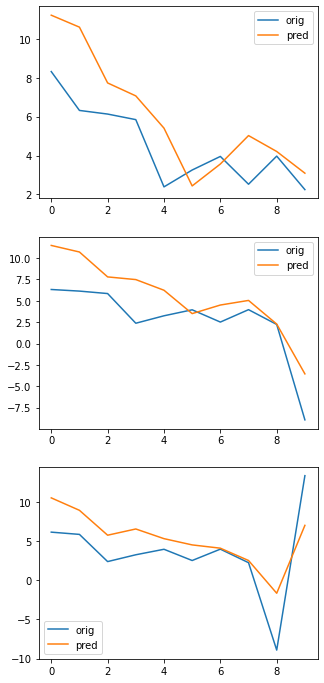

In [54]:
plot_pred(dn_y_test,dn_y_pred)

In [55]:
import matplotlib.pyplot as plt

In [93]:
def plot_pred2(orig,pred,last_year, horizon):
    n = len(orig)
    y_o, y_p = orig.T, pred.T
    df = pd.DataFrame()
    df['year'] = [last_year-(n-i+2) for i in range(n)]
    df['orig_1'] = y_o[0]
    df['orig_2'] = y_o[1]
    df['orig_3'] = y_o[2]
    df['pred_1'] = y_p[0]
    df['pred_2'] = y_p[1]
    df['pred_3'] = y_p[2]
    df = df.set_index('year')
    
    n = len(y_o)
    print(y_o.shape)
    for i in range(n):
        fig, ax = plt.subplots(figsize=(8,4))
        line_o, = ax.plot(df['orig_'+str(i+1)],label='orig')
        line_p, = ax.plot(df['pred_'+str(i+1)],label='pred')
        ax.legend(handles=[line_o,line_p])
        ax.set_title('Horizonte {} año'.format(i+1))
        ax.set_xlabel('Año')
        ax.set_ylabel('Crecimiento PBI (%)')
        plt.show()

        orig_1    orig_2     orig_3     pred_1     pred_2     pred_3
year                                                                
2009  8.332459  6.327192   6.139725  11.241747  11.479154  10.514531
2010  6.327192  6.139725   5.852518  10.624738  10.711029   8.926355
2011  6.139725  5.852518   2.382157   7.745833   7.799046   5.749106
2012  5.852518  2.382157   3.252245   7.077172   7.486181   6.544335
2013  2.382157  3.252245   3.953319   5.412615   6.239856   5.309126
2014  3.252245  3.953319   2.518835   2.431536   3.507708   4.511226
2015  3.953319  2.518835   3.969351   3.562262   4.511016   4.091669
2016  2.518835  3.969351   2.240632   5.029323   5.048435   2.521101
2017  3.969351  2.240632  -8.913955   4.208449   2.284848  -1.659886
2018  2.240632 -8.913955  13.349509   3.088517  -3.538058   7.005469
(3, 10)


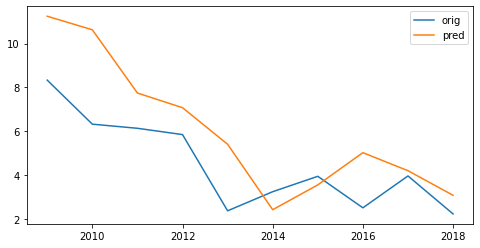

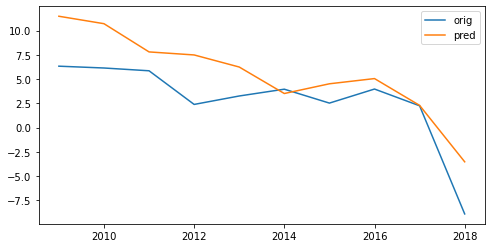

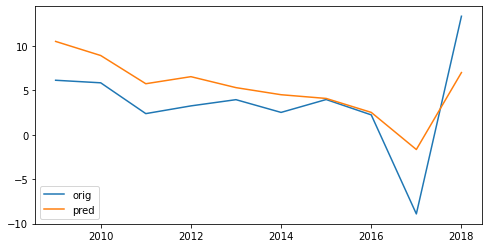

In [94]:
plot_pred2(dn_y_test,dn_y_pred,2021,3)